In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from robot import *
from geo import *
from drawing import *
from dataprovider import *

In [2]:
############## ADD / MODIFY CODE BELOW ####################

# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(param1, param2, param3):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    N = 100
    #myrobot.set_steering_drift(10.0 / 180.0 * pi) # 10 degree bias, this will be added in by the move function, you do not need to add it below!
    #
    # Enter code here
    #
    
    int_cte = 0.0
    cte = myrobot.y
    
    for i in range(N):
        dcte = myrobot.y - cte
        cte = myrobot.y
        int_cte += cte
        steer = -param1 * cte - param2 * dcte - param3 * int_cte
        myrobot = myrobot.move(steer, speed)
        
        print( myrobot, steer )

# Call your function with parameters of (0.2, 3.0, and 0.004)
#run(0.2, 3.0, 0.04)

In [3]:
filename='data/000/driving_log.csv'
position_data = load_simulator_data(filename)
len(position_data)

7684

In [4]:
print([float(x) for x in "1239.393:754.3097:29.65825".split(":")])
print([position_data[0][1][4], position_data[0][1][5], position_data[0][1][6]])

[1239.393, 754.3097, 29.65825]
[1239.393, 754.30970000000002, 29.658249999999999]


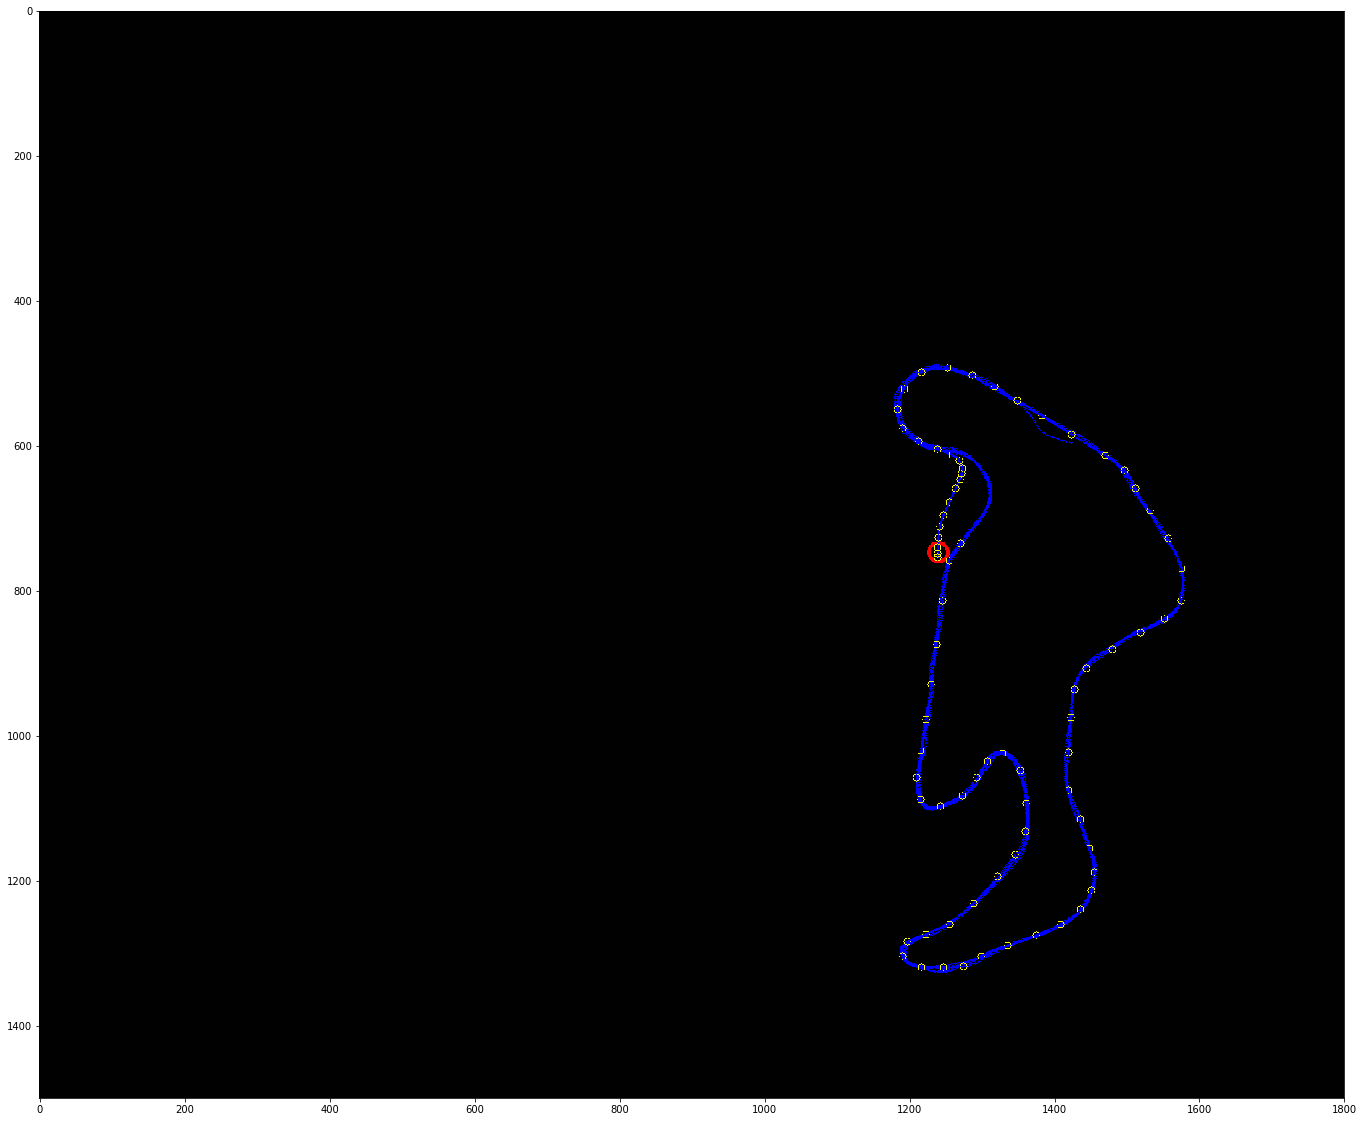

In [5]:
import cv2
img = np.ones((1500,1800, 3), np.uint8) 

cv2.circle(img, (1240, 747), 13, (255,0,0), 3)
#cv2.circle(img, (1235, 865), 5, (255,0,0), 3)

keypoints = []

for idx, p in enumerate (position_data):
    pos = (int(p[1][4]), int(p[1][5]))
    cv2.circle(img,pos, 1, (0,0,255))
    
for idx, p in enumerate (position_data):    
    if idx % 25 == 0 and idx<1900:
        pos = (int(p[1][4]), int(p[1][5]))
        cv2.circle(img, pos, 5, (255,255,0), 1)
        keypoints.append(pos)

plt.figure(figsize=(40,20))
plt.imshow(img)

In [ ]:
print(len(keypoints))

76


In [ ]:
import cv2
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy

imgcp = img.copy()
maxp = len(position_data) - 25
r=150.
x=500
y=500

start = get_pos(position_data[0])
end = get_pos(position_data[1])
speed = get_speed(position_data[0])

car = robot()
car.set(start[0], start[1], deg2rad(-82.))
#print(rad2deg(car.orientation))

def get_cte(keypoints, cp, change_at = 5):
    prev=keypoints[0]
    tp = (keypoints[0], keypoints[1])
    tpidx = 1
    mind = 1000.
    for idx, kp in enumerate(keypoints[1:]):
        d = distance(prev, kp, cp)
        if(mind>d):
            mind = d
            tp,tpidx = (prev, kp), idx
        prev = kp
    
    car_d=line_dist(cp, tp[1])
    if car_d<change_at:
        tpidx = tpidx+1
        tp=(tp[1],keypoints[tpidx])
        
    return mind, tp, tpidx

param1, param2, param3 = 0.2, 3.0, 0.04

int_cte = 0.0
cte = 0.0
dcte = 0.0
speed = 0.66
count = 0
tpidx = 1
tp = None
def make_frame(t):
    global car, tpidx, tp
    cp_img = np.copy(imgcp) 
    cte1, tp1, tpidx1 = get_cte(keypoints[tpidx:tpidx+10], (car.x,car.y))
    if tpidx1>=tpidx:
        tpidx=tpidx1
        tp = tp1
        cte=cte1
    if not tp:
        tp=tp1
        
    #cv2.line(cp_img,(int(car.x),int(car.y)), tp[1],  (255,255,255), 2)
    cv2.line(cp_img,tp[0], tp[1],  (255,255,255), 2)
    cv2.circle(cp_img, (int(car.x),int(car.y)), 3, (255,0,0),3)
    cv2.circle(cp_img,tp[0], 3, (25,255,155), 2)
    cv2.circle(cp_img,tp[1], 3, (255,255,0), 2)
    steer = get_heading((car.x, car.y), tp[1])
    steer = float(steer) % (2.0 * pi)
    steer = steer - car.orientation
    #steer = -param1 * cte - param2 * dcte - param3 * int_cte
    car = car.move(steer, speed)
    draw_steering(cp_img, 500,500,150, steer)
    cv2.putText(cp_img, str(rad2deg(steer))[:4], (300,300), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), cv2.LINE_AA)
    return cp_img

duration=(int(maxp/24)+1) 
#duration = 60
clip = mpy.VideoClip(make_frame, duration=duration) # 2 seconds
clip.write_videofile("steering.mp4",fps=24, codec='mpeg4')

"""
cv2.circle(imgcp, (int(car.x),int(car.y)), 3, (255,0,255),3)    
cv2.line(imgcp,(int(car.x),int(car.y)), keypoints[5],  (255,255,255), 2)
steer = get_heading((car.x, car.y), keypoints[5]) 
steer = float(steer) % (2.0 * pi)
steer = steer - car.orientation

print(rad2deg(car.orientation), rad2deg(sr))

for x in range(50):
    car = car.move(steer, 1)
    cv2.circle(imgcp, (int(car.x),int(car.y)), 1, (255,0,0),1)    

plt.figure(figsize=(30,20))
plt.imshow(imgcp)
"""

[MoviePy] >>>> Building video steering.mp4
[MoviePy] Writing video steering.mp4


 91%|█████████ | 6999/7681 [02:29<00:14, 46.50it/s]

In [ ]:
print(rad2deg(0.28))
16/25

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy
import cv2

imgcp = img.copy()
maxp = len(position_data) - 25
r=150.
x=500
y=500

start = get_pos(position_data[0])
end = get_pos(position_data[1])
speed = get_speed(position_data[0])

car = robot()
car.set(start[0], start[1], deg2rad(-82.))
#print(rad2deg(car.orientation))

def can_move_next_tp(keypoints, tpidx, cp, change_at = 5):            
    car_d=line_dist(cp, keypoints[tpidx])
    if car_d<change_at:
        return True
        
    return False

param1, param2, param3 = 0.2, 3.0, 0.04

int_cte = 0.0
cte = 0.0
dcte = 0.0
speed = 0.66
count = 0
tpidx = 2

def make_frame(t):
    global car, tpidx
    cp_img = np.copy(imgcp) 

    if can_move_next_tp(keypoints, tpidx, (int(car.x),int(car.y))):
        tpidx = (tpidx + 1) % (len(keypoints)-1)
        
    #cv2.line(cp_img,(int(car.x),int(car.y)), tp[1],  (255,255,255), 2)
    cv2.line(cp_img,keypoints[tpidx-1], keypoints[tpidx],  (255,255,255), 2)
    cv2.circle(cp_img, (int(car.x),int(car.y)), 3, (255,0,0),3)
    cv2.circle(cp_img,keypoints[tpidx-1], 3, (25,255,155), 2)
    cv2.circle(cp_img,keypoints[tpidx], 3, (255,255,0), 2)
    steer = get_heading((car.x, car.y), keypoints[tpidx])
    steer = float(steer) % (2.0 * pi)
    steer = steer - car.orientation
    #steer = -param1 * cte - param2 * dcte - param3 * int_cte
    car = car.move(steer, speed)
    draw_steering(cp_img, 500,500,150, steer)
    cv2.putText(cp_img, str(rad2deg(steer))[:4], (300,300), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), cv2.LINE_AA)
    return cp_img

duration=(int(maxp/24)+1) 
#duration = 60
clip = mpy.VideoClip(make_frame, duration=duration) # 2 seconds
clip.write_videofile("steering2.mp4",fps=24, codec='mpeg4')